In [86]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
%matplotlib inline

In [2]:
# read all band images in a directory
images = {}
image_dir = 'earthengine_images/'
for fn in os.listdir(image_dir):
    raw = gdal.Open(image_dir + fn)
    arr = raw.ReadAsArray()
    images[fn.split('.')[0]] = arr

In [3]:
for k, v in images.items():
    print(k + ' ' + str(v.shape))

LC80940862015351 (3, 117, 311)
LC80940862015335 (3, 117, 311)
LC80930862015248 (3, 117, 311)
LC80930862015088 (3, 117, 311)
LC80940862015047 (3, 117, 311)
LC80940862015095 (3, 117, 311)
LC80940862015159 (3, 117, 311)
LC80940862015111 (3, 117, 311)
LC80930862015152 (3, 117, 311)
LC80930862015168 (3, 117, 311)
LC80940862015175 (3, 117, 311)
LC80930862016059 (3, 117, 311)
LC80940862015079 (3, 117, 311)
LC80930862015232 (3, 117, 311)
LC80940862015239 (3, 117, 311)
LC80930862015040 (3, 117, 311)
LC80940862016002 (3, 117, 311)
LC80930862015328 (3, 117, 311)
LC80940862016018 (3, 117, 311)
LC80930862015184 (3, 117, 311)
LC80940862015191 (3, 117, 311)
LC80930862015264 (3, 117, 311)
LC80940862015319 (3, 117, 311)
LC80940862016082 (3, 117, 311)
LC80930862015056 (3, 117, 311)
LC80930862015344 (3, 117, 311)
LC80940862016034 (3, 117, 311)
LC80930862015120 (3, 117, 311)
LC80940862016066 (3, 117, 311)
LC80930862015216 (3, 117, 311)
LC80930862015280 (3, 117, 311)
LC80940862015127 (3, 117, 311)
LC809408

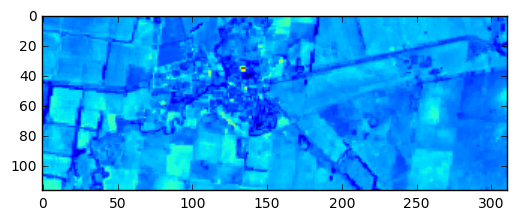

In [4]:
plt.imshow(images['LC80930862015040'][2, :, :])
plt.show()

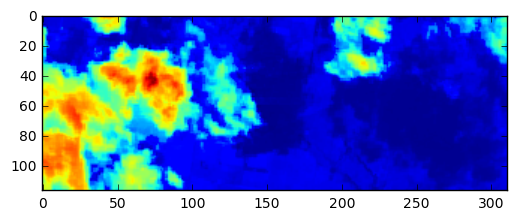

In [5]:
plt.imshow(images['LC80940862015079'][2, :, :])
plt.show()

In [6]:
# read all mask images in a directory
masks = {}
mask_dir = 'earthengine_masks/'
for fn in os.listdir(mask_dir):
    raw = gdal.Open(mask_dir + fn)
    arr = raw.ReadAsArray()
    masks[fn.split('.')[0]] = arr

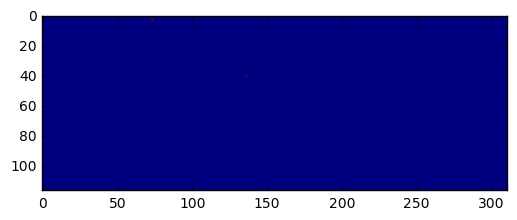

In [7]:
plt.imshow(masks['LC80930862015040'][0, :, :])
plt.show()

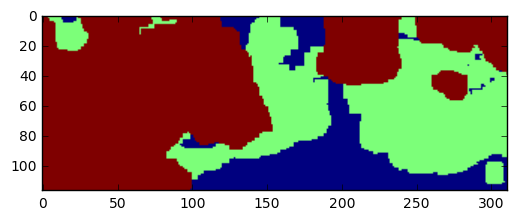

In [8]:
plt.imshow(masks['LC80940862015079'][0, :, :])
plt.show()

In [9]:
# compose band and mask images into one image
combined = {}
image_dir = 'earthengine_images/'
mask_dir = 'earthengine_masks/'
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

In [10]:
print(combined['LC80940862015079'].shape)

(5, 117, 311)


In [11]:
# use image names to look up metadata from csv export
table = pd.read_csv('earthengine_tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]

In [12]:
time_start

,system:index,system:time_start
0,LC80930862015040,1423440571231
1,LC80930862015056,1424822966175
2,LC80930862015072,1426205354132
3,LC80930862015088,1427587746370
4,LC80930862015120,1430352533188
5,LC80930862015136,1431734919028
6,LC80930862015152,1433117325195
7,LC80930862015168,1434499736147
8,LC80930862015184,1435882143244
9,LC80930862015200,1437264552573


In [13]:
time_start[time_start['system:index'] == 'LC80930862015040'].ix[0, 1]

1423440571231

In [14]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v

In [15]:
print(ds.keys())

dict_keys([1440634536577, 1432340092546, 1459382957827, 1445558982533, 1458000568200, 1433117325195, 1435882143244, 1440029363213, 1428192911630, 1433722502125, 1426205354132, 1453853382683, 1424822966175, 1442794176672, 1449706184998, 1442016943362, 1448323787335, 1452470982577, 1454458551604, 1450311357239, 1429575310943, 1436487319228, 1441411768125, 1424045737534, 1439252129269, 1427587746370, 1451088586307, 1430352533188, 1448928958023, 1438646955592, 1426810523472, 1456618171987, 1447546555861, 1444781749463, 1458605735131, 1423440571231, 1446164155488, 1451693755106, 1430957695975, 1446941385063, 1444176579436, 1457223342061, 1437869725294, 1455235776496, 1434499736147, 1431734919028, 1453076154238, 1443399349500, 1437264552573, 1435104908414])


In [16]:
# getting ready for interpolation / training

In [17]:
# get time series at a point
def getTS(data, x, y):
    times = list(data.keys())
    times.sort()
    ts = dict(map(lambda t: (t, data[t][:, x, y]), times))
    df = pd.DataFrame(ts).transpose()
#     df['date'] = df.index.map(lambda t: str(datetime.datetime.fromtimestamp(t/1000).date()))
    return df

In [18]:
df = getTS(ds, 20, 30)
df

,0,1,2,3,4
1423440571231,1908,1140,833,0,1
1424045737534,2214,1203,854,2,1
1424822966175,8770,8161,7738,4,3
1426205354132,1495,884,595,4,3
1426810523472,2080,1265,914,4,1
1427587746370,2065,1229,865,0,1
1428192911630,6130,5782,5672,4,3
1429575310943,3571,2966,2884,4,3
1430352533188,1808,1008,687,0,1
1430957695975,3759,3022,2872,4,3


cfmask: cloud mask.

    0=clear
    1=water
    2=shadow
    3=snow
    4=cloud

cfmask_conf: cloud mask confidence

    0=none
    1=cloud confidence ≤ 12.5%
    2=cloud confidence > 12.5% and ≤ 22.5%
    3=cloud confidence > 22.5%

In [19]:
def selectClear(df, level=1):
    return df.ix[(df.ix[:, 3] == 0) & (df.ix[:, 4] <= level), [0, 1, 2]]

In [20]:
clear = selectClear(df, 1)
clear

,0,1,2
1423440571231,1908,1140,833
1427587746370,2065,1229,865
1430352533188,1808,1008,687
1431734919028,1306,571,422
1433117325195,923,249,216
1437264552573,3093,166,304
1444176579436,4782,153,313
1444781749463,4198,186,319
1445558982533,3989,273,377
1446941385063,2987,597,578


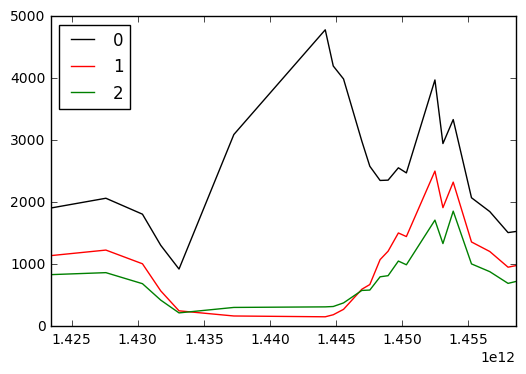

In [21]:
clear.plot(color=['k', 'r', 'g'])

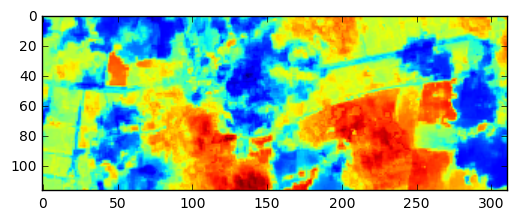

In [22]:
plt.imshow(ds[1444176579436][0, :, :])
plt.show()

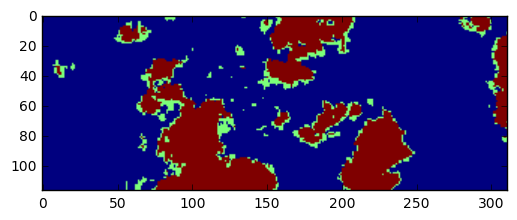

In [23]:
plt.imshow(ds[1444176579436][4, :, :])
plt.show()

In [24]:
str(datetime.datetime.fromtimestamp(1444176579436/1000).date())

'2015-10-07'

In [25]:
# interpolate at timestamp
def interpolate(data, timestamp):
    times = data.index
    if timestamp <= times[0]:
        values = data.iloc[0, :3]
    elif timestamp >= times[-1]:
        values = data.iloc[-1, :3]
    else:
        i = bisect.bisect(times, timestamp)
        delta_x = timestamp - times[i - 1]
        if delta_x == 0:
            values = data.iloc[i - 1, :3]
        else:
            low = data.iloc[i - 1, :3]
            high = data.iloc[i, :3]
            interval = (times[i] - times[i - 1])
            values = low + (high - low) / interval * delta_x
    return values

In [101]:
# 1427587746370
mid = int((1433117325195 + 1437264552573) / 2)
two = int((1450311357239 + 1452470982577) / 2)
print(mid)
interpolate(clear, mid)

1435190938884


0    2008.0
1     207.5
2     260.0
dtype: float64

In [102]:
# interpolate all points in an image

In [103]:
def interpolateImage(data, timestamps):
    dims = data[list(data.keys())[0]].shape
    dim_x = dims[1]
    dim_y = dims[2]
    images = {t: np.zeros((3, dim_x, dim_y)) for t in timestamps}
    for x in range(0, dim_x):
        for y in range(0, dim_y):
            data_point = getTS(data, x, y)
            clear_point = selectClear(data_point, 1)
            for timestamp in timestamps:
                values = interpolate(clear_point, timestamp)
                images[timestamp][:, x, y] = values
    return images

In [104]:
images = interpolateImage(ds, [mid, two])

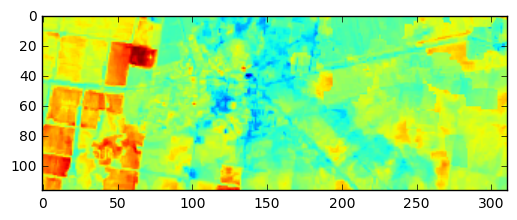

In [105]:
plt.imshow(images[two][0, :, :])
plt.show()

In [106]:
# remove cloud and interpolate

In [138]:
def convert_to_dataframe(image):
    frame = pd.Panel(image).to_frame()
    return frame

In [139]:
convert_to_dataframe(images[mid])

0           1           2
major minor                                     
0     0      1915.000000  213.000000  270.000000
      1      1926.000000  211.500000  270.500000
      2      1924.000000  216.500000  272.500000
      3      1924.000000  216.500000  272.500000
      4      1891.000000  210.000000  265.500000
      5      1829.000000  196.000000  248.500000
      6      1786.000000  185.000000  243.500000
      7      1786.500000  175.000000  242.500000
      8      1786.500000  175.000000  242.500000
      9      1756.500000  170.500000  232.000000
      10     1709.000000  185.000000  244.500000
      11     1712.000000  179.000000  232.500000
      12     1735.500000  180.000000  234.000000
      13     1735.500000  180.000000  234.000000
      14     1679.000000  225.500000  257.500000
      15     1790.000000  178.500000  241.000000
      16     1679.500000  216.000000  254.000000
      17     1711.500000  228.500000  261.500000
      18     1711.500000  228.500000  261.500000
      19     1770.500000  239.000000  264.500000
      20     1831.000000  251.500000  273.500000
      21     1869.000000  266.500000  282.000000
      22     1904.500000  279.500000  290.000000
      23     1904.500000  279.500000  290.000000
      24     1969.500000  293.500000  298.000000
      25     2022.000000  304.000000  306.000000
      26     1988.000000  282.500000  287.000000
      27     1988.000000  282.500000  287.000000
      28     1989.000000  271.000000  284.000000
      29     1929.000000  254.500000  278.000000
...                  ...         ...         ...
116   281    3133.624920  375.375010  493.125004
      282    3226.874897  378.500010  513.624998
      283    3212.124885  399.625011  511.999998
      284    3302.999870  387.875014  502.750000
      285    3302.999870  387.875014  502.750000
      286    3271.749870  432.250014  536.750000
      287    3110.749853  502.000022  578.750000
      288    2902.999873  596.625029  600.625008
      289    2838.624889  638.750024  625.875004
      290    2838.624889  638.750024  625.875004
      291    2846.624889  608.625019  620.375002
      292    2958.249871  524.125015  573.874998
      293    3074.499840  472.000022  506.750002
      294    3102.249825  479.500012  525.874995
      295    3102.249825  479.500012  525.874995
      296    2563.124909  350.500006  425.875001
      297    2480.124962  306.250016  375.749999
      298    3041.874892  457.500017  497.250006
      299    3002.624892  436.000014  501.875001
      300    3002.624892  436.000014  501.875001
      301    2777.624903  443.500006  472.874993
      302    2578.999942  365.625006  416.375002
      303    2868.124888  432.625016  491.750002
      304    2910.499890  378.375026  460.125009
      305    2910.499890  378.375026  460.125009
      306    2874.624894  402.000022  462.750007
      307    3013.499871  368.500022  461.750004
      308    2934.374881  391.750026  476.875004
      309    2934.374881  391.750026  476.875004
      310    2816.624905  421.625021  477.375003

[36387 rows x 3 columns]

In [154]:
def make_set(images):
    times = list(images.keys())
    res = pd.concat([convert_to_dataframe(i) for i in images.values()], axis=1, keys=images.keys())
#     res = pd.concat(list(map(convert_to_dataframe, images.values())), axis=0)
    return res.reset_index()

In [155]:
dataset = make_set(images)
dataset

major minor 1451391169908                 1435190938884              \
                              0       1       2             0           1   
0         0     0        2996.5  1825.5  1267.5   1915.000000  213.000000   
1         0     1        3069.5  1888.0  1307.0   1926.000000  211.500000   
2         0     2        3085.0  1912.0  1333.0   1924.000000  216.500000   
3         0     3        3113.0  1934.0  1352.0   1924.000000  216.500000   
4         0     4        3135.0  1933.0  1347.5   1891.000000  210.000000   
5         0     5        3115.5  1909.0  1346.5   1829.000000  196.000000   
6         0     6        3117.0  1912.5  1349.5   1786.000000  185.000000   
7         0     7        3129.0  1902.5  1336.5   1786.500000  175.000000   
8         0     8        3103.0  1891.0  1331.0   1786.500000  175.000000   
9         0     9        3109.5  1900.0  1333.0   1756.500000  170.500000   
10        0    10        3109.0  1916.5  1323.0   1709.000000  185.000000   
11        0    11        2978.0  1831.0  1267.5   1712.000000  179.000000   
12        0    12        2993.0  1895.0  1350.5   1735.500000  180.000000   
13        0    13        2982.0  1906.0  1364.0   1735.500000  180.000000   
14        0    14        3329.5  2126.0  1511.5   1679.000000  225.500000   
15        0    15        3104.0  1940.5  1368.0   1790.000000  178.500000   
16        0    16        3038.0  1899.5  1336.0   1679.500000  216.000000   
17        0    17        3088.0  1912.5  1345.5   1711.500000  228.500000   
18        0    18        3113.5  1927.5  1358.0   1711.500000  228.500000   
19        0    19        3153.0  1951.0  1377.5   1770.500000  239.000000   
20        0    20        3231.0  2007.5  1412.0   1831.000000  251.500000   
21        0    21        3269.0  2047.5  1433.5   1869.000000  266.500000   
22        0    22        3270.0  2066.5  1446.0   1904.500000  279.500000   
23        0    23        3266.0  2060.5  1443.0   1904.500000  279.500000   
24        0    24        3216.5  2028.0  1425.0   1969.500000  293.500000   
25        0    25        3179.5  1999.5  1412.0   2022.000000  304.000000   
26        0    26        3181.5  1985.0  1402.0   1988.000000  282.500000   
27        0    27        3175.5  1981.0  1402.5   1988.000000  282.500000   
28        0    28        3195.0  1969.5  1373.0   1989.000000  271.000000   
29        0    29        3183.0  1968.0  1363.5   1929.000000  254.500000   
...     ...   ...           ...     ...     ...           ...         ...   
36357   116   281        3013.5  1648.5  1161.0   3133.624920  375.375010   
36358   116   282        3078.0  1695.0  1192.0   3226.874897  378.500010   
36359   116   283        3173.0  1744.0  1229.0   3212.124885  399.625011   
36360   116   284        3177.5  1760.0  1237.0   3302.999870  387.875014   
36361   116   285        3179.5  1773.0  1249.0   3302.999870  387.875014   
36362   116   286        3168.5  1734.5  1211.5   3271.749870  432.250014   
36363   116   287        3226.0  1747.0  1219.0   3110.749853  502.000022   
36364   116   288        3199.5  1722.0  1202.5   2902.999873  596.625029   
36365   116   289        3145.5  1689.5  1178.0   2838.624889  638.750024   
36366   116   290        3102.0  1663.0  1155.5   2838.624889  638.750024   
36367   116   291        3015.5  1620.5  1129.5   2846.624889  608.625019   
36368   116   292        2946.0  1619.0  1139.0   2958.249871  524.125015   
36369   116   293        2957.0  1584.0  1131.5   3074.499840  472.000022   
36370   116   294        2943.0  1601.0  1151.0   3102.249825  479.500012   
36371   116   295        2941.0  1619.0  1147.5   3102.249825  479.500012   
36372   116   296        2792.5  1390.0   922.0   2563.124909  350.500006   
36373   116   297        3024.5  1268.5   957.5   2480.124962  306.250016   
36374   116   298        3014.0  1474.0  1083.0   3041.874892  457.500017   
36375   116   299        2945.5  1596.0  1136.5   3002.624892  436.000014   
36